In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# BCE classifier

> API details.

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim, autograd, nn, Tensor
import torch
from torch.distributions import Normal

In [4]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,1),  nn.Sigmoid())
init_net(net)

In [5]:
model = ModelWrapper(net)

data, test = get_paper_data(200000, bs=32, n_test=1000000)

In [7]:
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-3), loss=nn.BCELoss(),
          cbs=[LossTracker(),SaveBest('weights/best_bce.h5'),EarlyStopping(10)])

1: Train=0.4222367459440231 Valid=0.3818375404167175
2: Train=0.36534119380235675 Valid=0.3526139043903351
3: Train=0.3473478007388115 Valid=0.34299325704574585
4: Train=0.3413536496305466 Valid=0.3396366716194153
5: Train=0.33937821600914003 Valid=0.3384710033082962
6: Train=0.3386472702217102 Valid=0.3385546123313904
7: Train=0.33820967024326326 Valid=0.337892559633255
8: Train=0.3379470380961895 Valid=0.3375563053226471
9: Train=0.33775099663853647 Valid=0.3377980812454224
10: Train=0.3374708180272579 Valid=0.33695298463344575
11: Train=0.3372348613536358 Valid=0.3370100667047501
12: Train=0.33706380971908567 Valid=0.3366574294996262
13: Train=0.33682140608787536 Valid=0.33659679384231567
14: Train=0.3367246814119816 Valid=0.33639496898174287
15: Train=0.33647885818719864 Valid=0.33636334522247313
16: Train=0.33628102334737775 Valid=0.336374228682518
17: Train=0.33615888860821724 Valid=0.33597907242298125
18: Train=0.33603640856862066 Valid=0.33593755472660064
19: Train=0.3358787017

In [8]:
model.save('weights/BCE_Test.h5')

In [6]:
model.load('weights/BCE_Test.h5')

## BM 0

In [7]:
preds = model._predict_dl(test)

In [8]:
preds

array([[0.8578834 ],
       [0.9488406 ],
       [0.76114553],
       ...,
       [0.0454307 ],
       [0.20448458],
       [0.11298872]], dtype=float32)

In [9]:
df = pd.DataFrame({'pred':preds.squeeze()})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,0.857883,1.0
1,0.948841,1.0
2,0.761146,1.0
3,0.196065,1.0
4,0.864609,1.0


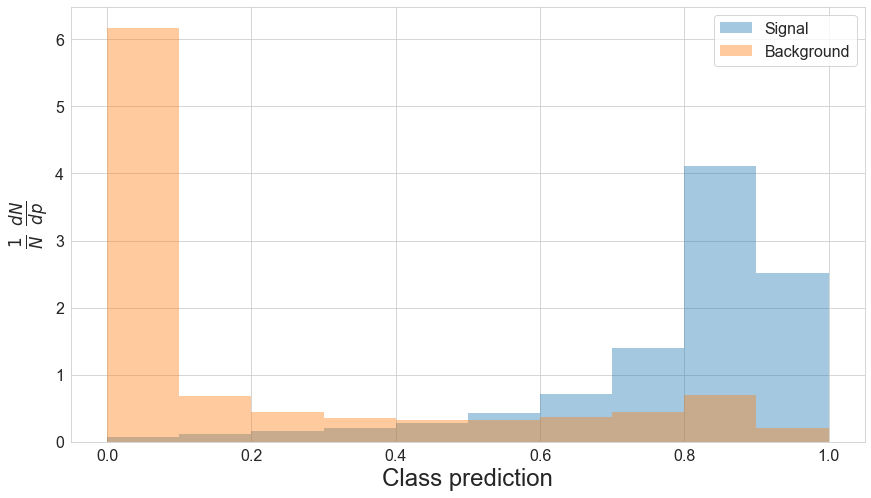

In [10]:
plot_preds(df)

In [11]:
bin_preds(df, np.linspace(0,1,11))

In [12]:
df.head()

,pred,gen_target,pred_bin
0,0.857883,1.0,8
1,0.948841,1.0,9
2,0.761146,1.0,7
3,0.196065,1.0,1
4,0.864609,1.0,8


In [13]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [14]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.0000))

In [15]:
f_s, f_b

(tensor([0.0073, 0.0116, 0.0157, 0.0206, 0.0283, 0.0429, 0.0714, 0.1399, 0.4108,
         0.2514]),
 tensor([0.6174, 0.0676, 0.0440, 0.0356, 0.0323, 0.0329, 0.0364, 0.0447, 0.0691,
         0.0199]))

In [16]:
asimov = (50*f_s)+(1000*f_b)

In [17]:
asimov, asimov.sum()

(tensor([617.7573,  68.2296,  44.7587,  36.6600,  33.7435,  35.0207,  39.9990,
          51.6637,  89.6903,  32.4772]), tensor(1050.))

In [18]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([31.83293915, 31.67533112, 31.52416229, 31.37927246, 31.24090576,
       31.10800171, 30.98161316, 30.86146545, 30.7469635 , 30.63850403,
       30.53562927, 30.43830109, 30.34638214, 30.26026154, 30.17946625,
       30.1042099 , 30.03436279, 29.96957397, 29.90971375, 29.8551712 ,
       29.80571747, 29.76119232, 29.72164917, 29.68694305, 29.65680695,
       29.6315918 , 29.61141205, 29.59588623, 29.58464813, 29.57793427,
       29.57566833, 29.57794189, 29.58423615, 29.59515381, 29.6103363 ,
       29.62980652, 29.65341949, 29.68119049, 29.71283722, 29.74876404,
       29.7891922 , 29.8328476 , 29.88105011, 29.93267059, 29.98834991,
       30.04748535, 30.11065674, 30.17756653, 30.2481842 , 30.32276154,
       30.40063477, 30.48160553, 30.56694794, 30.65557098, 30.74756622,
       30.84307098, 30.942276  , 31.04460907, 31.15024567, 31.25902557,
       31.37153625])

In [19]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [20]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

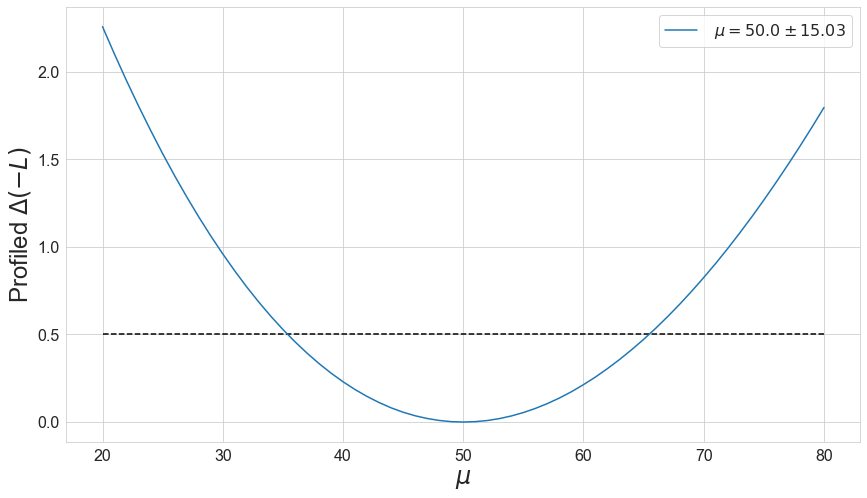

[15.027211579865511]

In [23]:
plot_likelihood(y-y.min(), mu_scan=x)

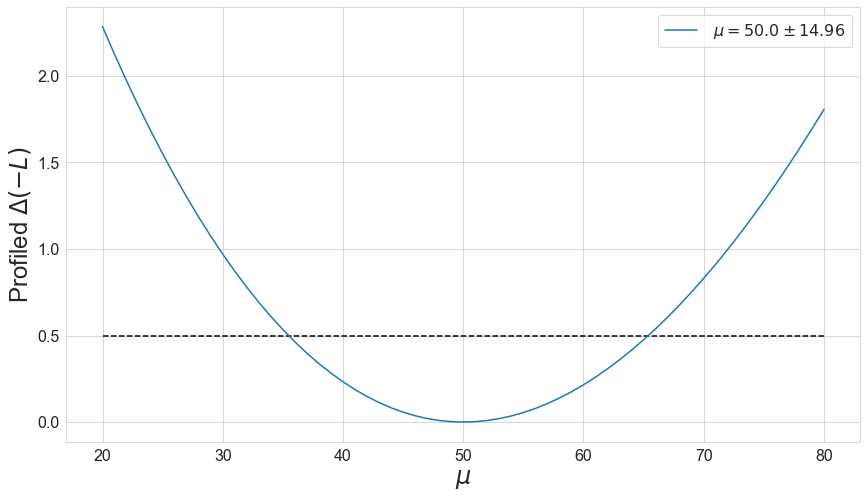

[14.961309421595722]

In [25]:
plot_likelihood(y_tf2-y_tf2.min(), mu_scan=x)

# Nuisances - via interpolation

In [26]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [27]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, bins=np.linspace(0,1,11))

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [28]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,8.578834e-01,1.0,8,8.578834e-01,8,8.578834e-01,8,8.578834e-01,8,8.578834e-01,8,8.578834e-01,8
1,9.488406e-01,1.0,9,9.488406e-01,9,9.488406e-01,9,9.488406e-01,9,9.488406e-01,9,9.488406e-01,9
2,7.611455e-01,1.0,7,7.611455e-01,7,7.611455e-01,7,7.611455e-01,7,7.611455e-01,7,7.611455e-01,7
3,1.960649e-01,1.0,1,1.960649e-01,1,1.960649e-01,1,1.960649e-01,1,1.960649e-01,1,1.960649e-01,1
4,8.646089e-01,1.0,8,8.646089e-01,8,8.646089e-01,8,8.646089e-01,8,8.646089e-01,8,8.646089e-01,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,6.509241e-04,0.0,0,1.009280e-03,0,6.509241e-04,0,4.200167e-04,0,6.435804e-04,0,6.583510e-04,0
999996,2.199039e-09,0.0,0,2.526959e-09,0,2.199039e-09,0,1.954833e-09,0,2.140609e-09,0,2.259059e-09,0
999997,4.543070e-02,0.0,0,6.966504e-02,0,4.543070e-02,0,2.942614e-02,0,4.462140e-02,0,4.692930e-02,0
999998,2.044846e-01,0.0,2,1.905785e-01,1,2.044846e-01,2,2.085534e-01,2,2.030118e-01,2,2.052914e-01,2


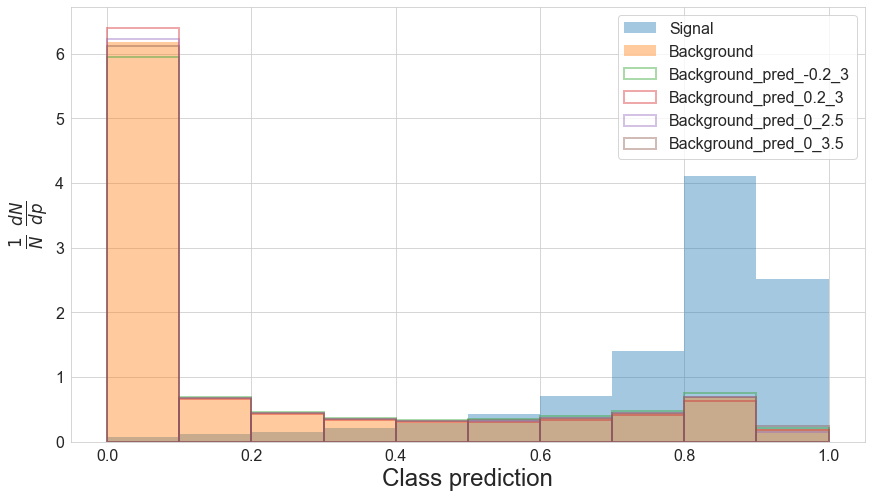

In [29]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'])

In [30]:
b_shapes['f_b_nom']

tensor([0.6174, 0.0676, 0.0440, 0.0356, 0.0323, 0.0329, 0.0364, 0.0447, 0.0691,
        0.0199])

In [31]:
b_shapes['f_b_up']

tensor([[0.6403, 0.0654, 0.0424, 0.0336, 0.0305, 0.0308, 0.0341, 0.0416, 0.0631,
         0.0182],
        [0.6125, 0.0675, 0.0443, 0.0355, 0.0324, 0.0330, 0.0365, 0.0446, 0.0696,
         0.0242]])

In [32]:
b_shapes['f_b_dw']

tensor([[0.5947, 0.0700, 0.0459, 0.0369, 0.0340, 0.0349, 0.0391, 0.0475, 0.0752,
         0.0218],
        [0.6224, 0.0678, 0.0438, 0.0354, 0.0322, 0.0328, 0.0366, 0.0443, 0.0690,
         0.0157]])

In [33]:
f_s

tensor([0.0073, 0.0116, 0.0157, 0.0206, 0.0283, 0.0429, 0.0714, 0.1399, 0.4108,
        0.2514])

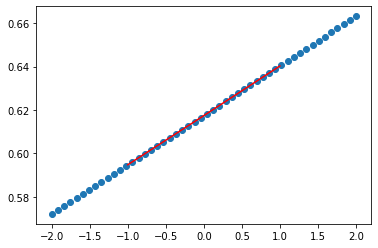

In [37]:
i = 0
d = b_shapes['f_b_dw'][0][i]
n = b_shapes['f_b_nom'][i]
u = b_shapes['f_b_up'][0][i]
interp = []
rs = np.linspace(-2,2)
for r in rs: interp.append(interp_shape(Tensor((r,0))[None,:], f_nom=b_shapes['f_b_nom'], f_up=b_shapes['f_b_up'], f_dw=b_shapes['f_b_dw'])[0][i].data.item())
plt.scatter(rs, interp)
plt.plot([-1,0,1],[d,n,u], label=i, color='r')

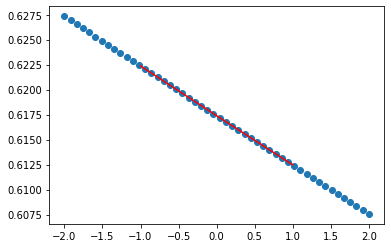

In [36]:
i = 0
d = b_shapes['f_b_dw'][1][i]
n = b_shapes['f_b_nom'][i]
u = b_shapes['f_b_up'][1][i]
interp = []
ls = np.linspace(-2,2)
for l in ls: interp.append(interp_shape(Tensor((0,l))[None,:], f_nom=b_shapes['f_b_nom'], f_up=b_shapes['f_b_up'], f_dw=b_shapes['f_b_dw'])[0][i].data.item())
plt.scatter(ls, interp)
plt.plot([-1,0,1],[d,n,u], label=i, color='r')

In [35]:
b_shapes['f_b_nom']

tensor([6.8475e-01, 4.4522e-02, 3.4762e-02, 3.2348e-02, 3.2874e-02, 3.7072e-02,
        4.4540e-02, 6.9334e-02, 1.9794e-02, 2.0000e-13])

In [36]:
alpha = Tensor((1,0))[None,:]
interp_shape(alpha, **b_shapes).squeeze()

tensor([7.0599e-01, 4.1730e-02, 3.3740e-02, 3.0436e-02, 3.0690e-02, 3.4592e-02,
        4.1342e-02, 6.3348e-02, 1.8136e-02, 2.0000e-13])

In [37]:
b_shapes['f_b_up']

tensor([[7.0599e-01, 4.1730e-02, 3.3740e-02, 3.0436e-02, 3.0690e-02, 3.4592e-02,
         4.1342e-02, 6.3348e-02, 1.8136e-02, 2.0000e-13],
        [6.7950e-01, 4.4862e-02, 3.4880e-02, 3.2510e-02, 3.2826e-02, 3.6730e-02,
         4.5110e-02, 6.9540e-02, 2.4040e-02, 2.0000e-13]])

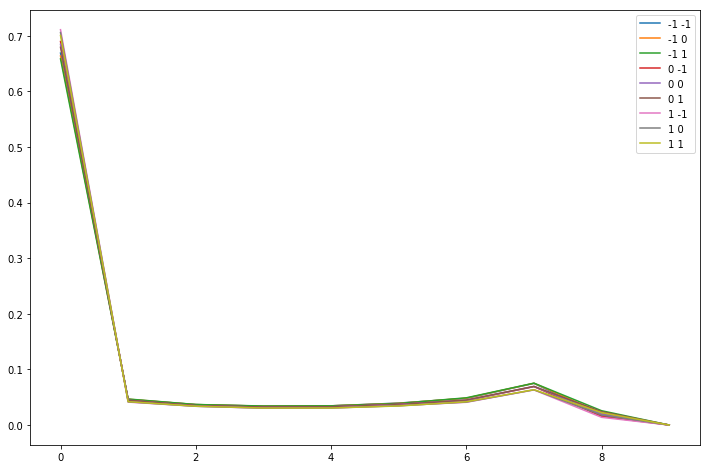

In [38]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [14]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [40]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [41]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [42]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [43]:
nll = to_np(nll)

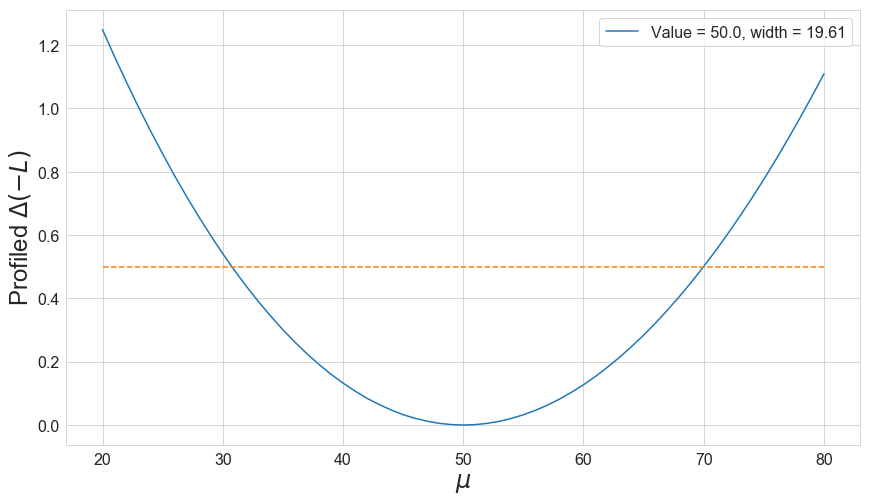

In [44]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [45]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [46]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

Linear regime: Mu 20.0, alpha tensor([1.7136])
Linear regime: Mu 21.0, alpha tensor([1.6563])
Linear regime: Mu 22.0, alpha tensor([1.5989])
Linear regime: Mu 23.0, alpha tensor([1.5416])
Linear regime: Mu 24.0, alpha tensor([1.4843])
Linear regime: Mu 25.0, alpha tensor([1.4270])
Linear regime: Mu 26.0, alpha tensor([1.3697])
Linear regime: Mu 27.0, alpha tensor([1.3125])
Linear regime: Mu 28.0, alpha tensor([1.2552])
Linear regime: Mu 29.0, alpha tensor([1.1980])
Linear regime: Mu 30.0, alpha tensor([1.1408])
Linear regime: Mu 31.0, alpha tensor([1.0836])
Linear regime: Mu 32.0, alpha tensor([1.0265])
Linear regime: Mu 69.0, alpha tensor([-1.0582])
Linear regime: Mu 70.0, alpha tensor([-1.1138])
Linear regime: Mu 71.0, alpha tensor([-1.1694])
Linear regime: Mu 72.0, alpha tensor([-1.2250])
Linear regime: Mu 73.0, alpha tensor([-1.2805])
Linear regime: Mu 74.0, alpha tensor([-1.3361])
Linear regime: Mu 75.0, alpha tensor([-1.3916])
Linear regime: Mu 76.0, alpha tensor([-1.4472])
Linea

In [47]:
nll = to_np(nll)

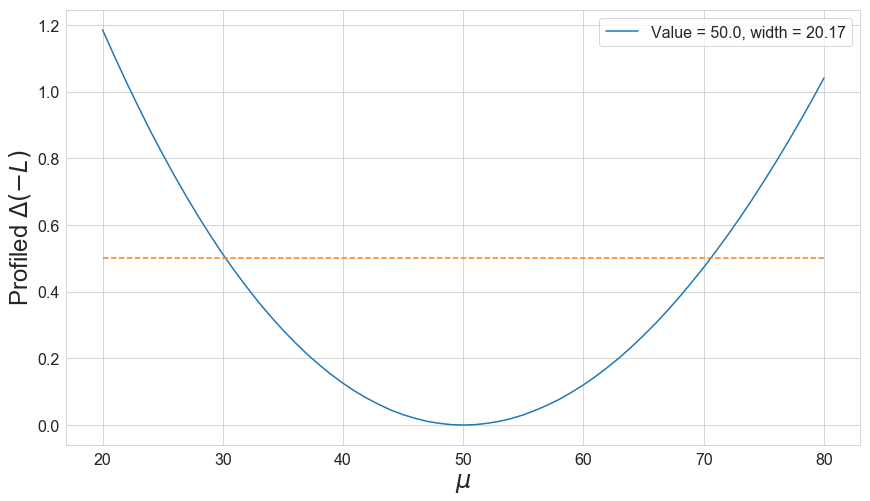

In [48]:
plot_likelihood(nll-nll.min())

## BM 2

In [49]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.6725,  1.2197])
Linear regime: Mu 21.0, alpha tensor([-0.6492,  1.1797])
Linear regime: Mu 22.0, alpha tensor([-0.6260,  1.1396])
Linear regime: Mu 23.0, alpha tensor([-0.6028,  1.0995])
Linear regime: Mu 24.0, alpha tensor([-0.5797,  1.0593])
Linear regime: Mu 25.0, alpha tensor([-0.5566,  1.0191])
Linear regime: Mu 75.0, alpha tensor([ 0.5115, -1.0318])
Linear regime: Mu 76.0, alpha tensor([ 0.5306, -1.0739])
Linear regime: Mu 77.0, alpha tensor([ 0.5495, -1.1160])
Linear regime: Mu 78.0, alpha tensor([ 0.5684, -1.1582])
Linear regime: Mu 79.0, alpha tensor([ 0.5871, -1.2005])
Linear regime: Mu 80.0, alpha tensor([ 0.6058, -1.2429])


In [50]:
nll = to_np(nll)

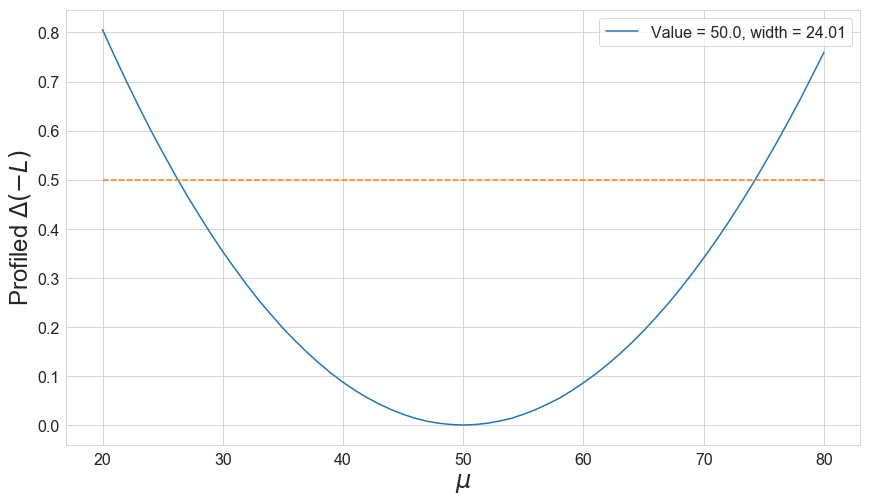

In [51]:
plot_likelihood(nll-nll.min())

## BM 3

In [15]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [16]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [17]:
nll = to_np(nll)

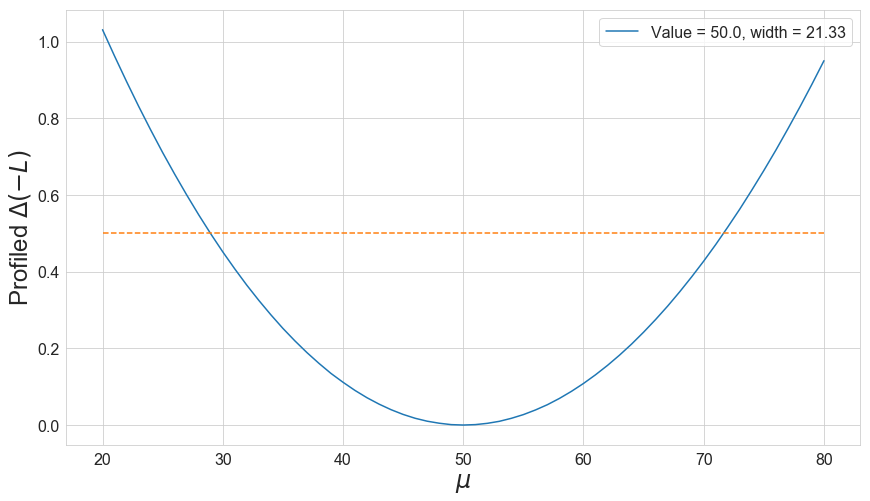

In [18]:
plot_likelihood(nll-nll.min())

## BM 4

In [19]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [20]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.6107,  0.9176, 26.4084])
Linear regime: Mu 21.0, alpha tensor([-0.5902,  0.8878, 25.4921])
Linear regime: Mu 22.0, alpha tensor([-0.5696,  0.8579, 24.5783])
Linear regime: Mu 23.0, alpha tensor([-0.5491,  0.8280, 23.6670])
Linear regime: Mu 24.0, alpha tensor([-0.5286,  0.7980, 22.7582])
Linear regime: Mu 25.0, alpha tensor([-0.5081,  0.7679, 21.8520])
Linear regime: Mu 26.0, alpha tensor([-0.4877,  0.7378, 20.9482])
Linear regime: Mu 27.0, alpha tensor([-0.4672,  0.7076, 20.0469])
Linear regime: Mu 28.0, alpha tensor([-0.4468,  0.6774, 19.1481])
Linear regime: Mu 29.0, alpha tensor([-0.4263,  0.6471, 18.2518])
Linear regime: Mu 30.0, alpha tensor([-0.4059,  0.6168, 17.3580])
Linear regime: Mu 31.0, alpha tensor([-0.3855,  0.5864, 16.4666])
Linear regime: Mu 32.0, alpha tensor([-0.3651,  0.5559, 15.5778])
Linear regime: Mu 33.0, alpha tensor([-0.3447,  0.5254, 14.6914])
Linear regime: Mu 34.0, alpha tensor([-0.3243,  0.4949, 13.8076])
Linear reg

In [21]:
nll = to_np(nll)

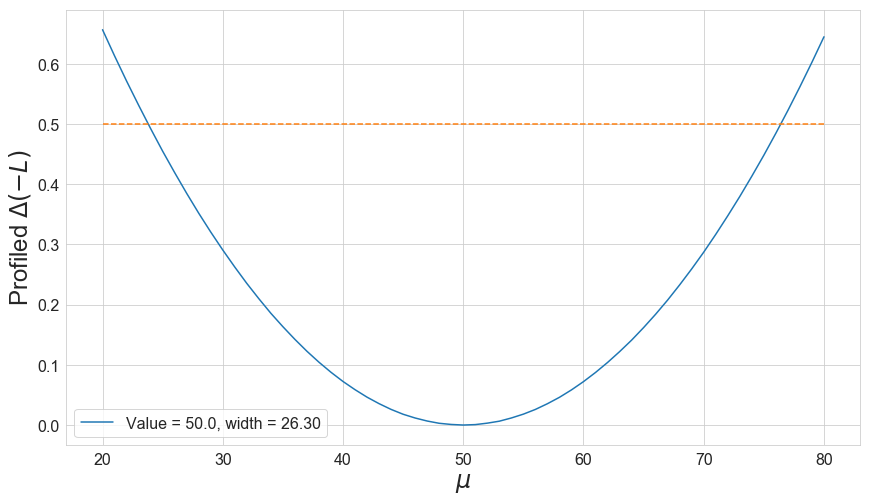

In [22]:
plot_likelihood(nll-nll.min())